In [1]:
%matplotlib inline
from swsvr.SlidingWindowBasedSVR import SlidingWindowBasedSVR
from  swsvr import DataStructure
import swsvr.Utility as ut
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import cPickle as pickle
import time

In [2]:
def visualization(true_y, swsvr_result, other):
    name=[]
    mape=[]
    print "+ Each prediction error for MAPE"
    name.append("swsvr")
    print "SWSVR: ",
    tmp_mape = ut.metrics(true_y, swsvr_result, is_print = True)
    mape.append(tmp_mape)

    for l in simple_learners:
        name.append(l.name)
        print "%s: " % l.name,
        tmp_mape = ut.metrics(true_y, l.result,  is_print = True)
        mape.append(tmp_mape)

    df = pd.DataFrame({'true':true_y, 'swsvr':swsvr_result})
    for l in other:
        tmp = pd.DataFrame({l.name:l.result})
        df = pd.concat([df,tmp],axis=1)

    plt.figure(figsize=(12,8))
    plt.subplot2grid((2, 1), (0, 0))
    sea.barplot(x=name,y=mape)
    plt.axhline(y=mape[0], color='r', ls=':')
    plt.title("MAPE")
    plt.subplot2grid((2, 1), (1, 0))
    plt.plot(true_y,lw=2,label='true')
    plt.plot(swsvr_result,lw=1,alpha=0.8,label='swsvr')
    plt.xlim(0, len(true_y))
    for l in other:
        plt.plot(l.result,'--',lw=1,alpha=0.7,label=l.name)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='center', borderaxespad=0, ncol=10)
    plt.title("Regression curve")
    plt.show()

In [3]:
if __name__ == '__main__':
    is_tune=False
    print "+ Load SDC data and testdata about AMeDAS"
    print "+ SDC data is also training data for all methods"
    print "training periods: September 1, 2011 to September 1, 2015 (for 3 years)"
    print "testing periods: September 1, 2015 to March 1, 2016 (for 6 months)"
    print "prediction horizon: 6 hours"
    # sample parameters to tune
    swsvr_params = {'svr_cost': [4, 8, 16, 32, 64, 126],
                    'svr_epsilon': [0.001, 0.00001],
                    'svr_intercept': [32, 8, 64, 16, 128],
                    'svr_itr':[100000],
                    'kapp_gamma': [0.00001],
                    'kapp_num': [100],
                    'pls_compnum': [50],
                    'sdc_weight': [0.5],
                    'predict_weight': [3],
                    'lower_limit': [10],
                    'n_estimators':[100, 500]}
    # load pkl
    with open('sdc_data_20110901_20140901_6h.pkl', 'rb') as f:
        sdc_data = pickle.load(f)
    with open('test_data_20140901_20150301_6h.pkl', 'rb') as f:
        test_data = pickle.load(f)

+ Load SDC data and testdata about AMeDAS
+ SDC data is also training data for all methods
training periods: September 1, 2011 to September 1, 2015 (for 3 years)
testing periods: September 1, 2015 to March 1, 2016 (for 6 months)
prediction horizon: 6 hours


In [4]:
    print "+ SDC data summary"
    print "+ fol_X == pre_X after 6hours"
    print "SDC_data.pre_X.shape -> " + str(sdc_data.pre_X.shape)
    print "SDC_data.pre_y.shape -> " + str(sdc_data.pre_y.shape)
    print "SDC_data.fol_X.shape -> " + str(sdc_data.fol_X.shape)
    print "\n+ test data summary"
    print "test_data.X.shape -> " + str(test_data.X.shape)
    print "test_data.y.shape -> " + str(test_data.y.shape)

+ SDC data summary
+ fol_X == pre_X after 6hours
SDC_data.pre_X.shape -> (157824L, 5L)
SDC_data.pre_y.shape -> (157824L,)
SDC_data.fol_X.shape -> (157824L, 5L)

+ test data summary
test_data.X.shape -> (26058L, 5L)
test_data.y.shape -> (26058L,)


In [33]:
    print "+ Build SWSVR"
    if is_tune:
        swsvr = ut.grid_tuning(swsvr_params, sdc_data, test_data)
    else:
        swsvr = SlidingWindowBasedSVR()
    swsvr.train(sdc_data)
    print "SWSVR: finish to build the model"

+ Build SWSVR
SWSVR: finish to build the model


In [34]:
    print "+ Build other models"
    simple_learners = ut.build_other_learners(sdc_data.pre_X, sdc_data.pre_y)

+ Build other models
rf: finish to build the model
gb: finish to build the model
linearSVR: finish to build the model
svr: finish to build the model


+ Predicttion and Visualization
+ Each prediction error for MAPE
SWSVR:  34.9942445617
rf:  47.5339024607
gb:  45.6807606868
linearSVR:  45.2467948457
svr:  37.4604755522


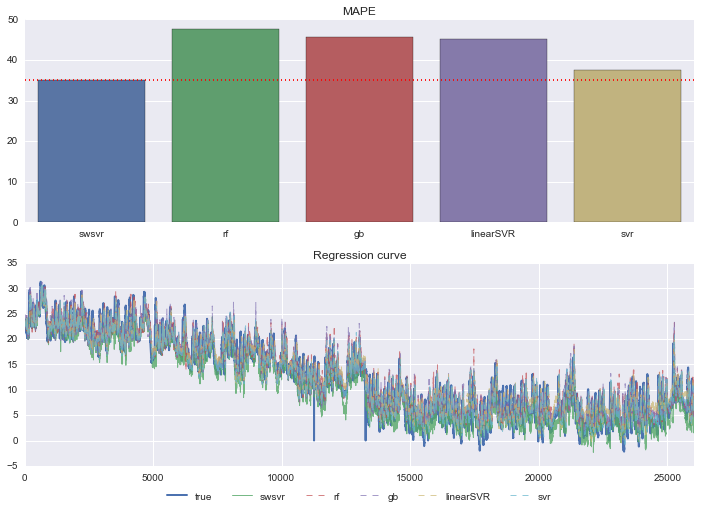

In [35]:
    print "+ Predicttion and Visualization"
    # predict
    swsvr_result, true_y = swsvr.predict(test_data.X), test_data.y
    for l in simple_learners: l.predict(test_data.X)
    # visualize
    visualization(true_y, swsvr_result, simple_learners)